In [1]:
import os

import h5py
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import tensorflow as tf
from sklearn import model_selection
from tensorflow import keras

data_dir = os.environ.get("DATA_DIR") + "lidar_ml/real_data/"

2023-11-01 18:07:40.102550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with h5py.File(data_dir + "simulation/100x100x10000_smooth=0.5_avg=0_rnd=10.hdf5", "r") as f:
    data1 = np.array(f["spectrum"], dtype=np.float32)
    data2 = np.array(f["spectrum_perfect"], dtype=np.float32)
    data3 = np.array(f["wind_profile"], dtype=np.float32)

for i in range(100):
    data1[:, i, :] *= ((i + 5) / 5) ** 2 / 1000

for i in range(data1.shape[0]):
    for j in range(100):
        total = np.sum(data2[i, j, :])
        if total < 7:
            data2[i, j, :] *= 0
        else:
            data2[i, j, :] *= 5 / total

x_data = np.pad(data1, np.array(((0, 0), (14, 14), (14, 14))), mode="symmetric").reshape((-1, 128, 128, 1))
y_data = np.pad(data2, np.array(((0, 0), (14, 14), (14, 14))), mode="symmetric").reshape((-1, 128, 128, 1))

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=42)

data1 = ""
data2 = ""
data3 = ""

In [3]:
with h5py.File(data_dir + "simulation/100x100x10000_smooth=0.5_avg=0_rnd=10.hdf5", "r") as f:
    data1 = np.array(f["spectrum"], dtype=np.float32)
    data2 = np.array(f["spectrum_perfect"], dtype=np.float32)
    data3 = np.array(f["wind_profile"], dtype=np.float32)

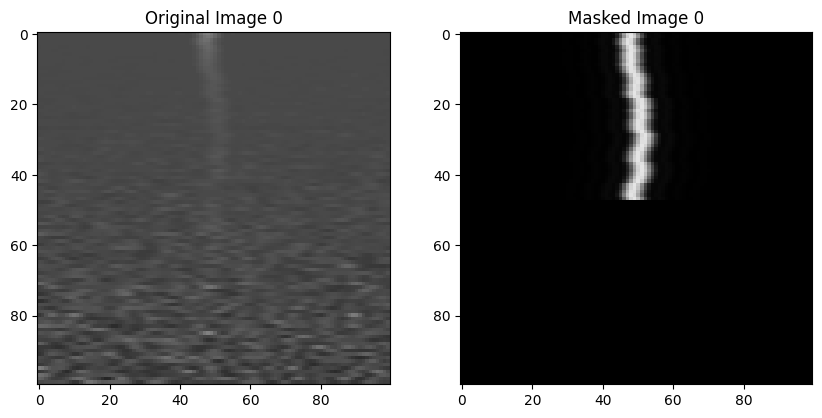

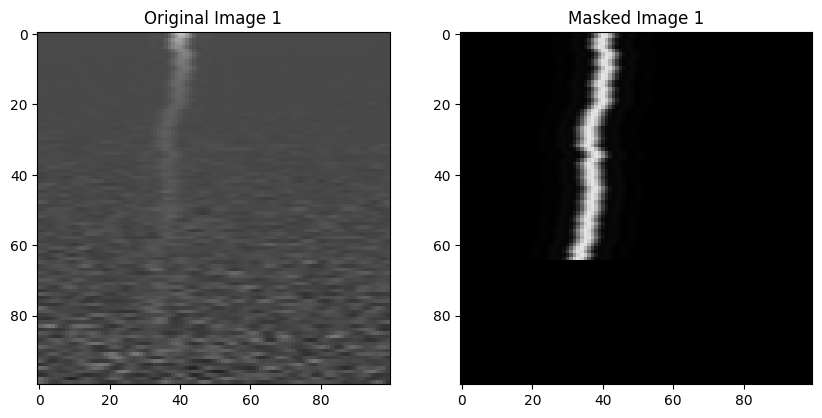

In [4]:
show_images = 2
for i in range(show_images):
    img1 = x_data[i, 14:114, 14:114]
    img2 = y_data[i, 14:114, 14:114]
    fig, arr = plt.subplots(1, 2, figsize=(10, 10))
    arr[0].imshow(img1, cmap="gray", vmin=-2, vmax=5)
    arr[0].set_title("Original Image " + str(i))
    arr[1].imshow(img2, cmap="gray", vmin=0, vmax=1)
    arr[1].set_title("Masked Image " + str(i))

In [5]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.0, max_pooling=True):
    conv = keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="HeNormal")(inputs)  # Kernel size
    conv = keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="HeNormal")(conv)  # Kernel size

    conv = keras.layers.BatchNormalization()(conv, training=False)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        # next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
        next_layer = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = keras.layers.Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding="same")(prev_layer_input)  # Kernel size

    merge = keras.layers.concatenate([up, skip_layer_input], axis=3)

    conv = keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="HeNormal")(merge)  # Kernel size
    conv = keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="HeNormal")(conv)  # Kernel size
    return conv


def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    inputs = keras.layers.Input(input_size)

    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters * 2, dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters * 4, dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters * 8, dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)

    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1], n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1], n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1], n_filters)

    conv9 = keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="he_normal")(ublock9)
    conv10 = keras.layers.Conv2D(n_classes, 1, padding="same")(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [6]:
unet = UNetCompiled(input_size=(128, 128, 1), n_filters=8, n_classes=1)
# unet.summary()

2023-11-01 18:07:53.209858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7391 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1


In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss_fn = keras.losses.MeanSquaredError()

array = np.pad(1.0 / np.arange(5, 105)[:, np.newaxis], np.array(((14, 14), (0, 127))), mode="symmetric")
loss_weight = tf.convert_to_tensor(array, dtype=tf.float32)


def loss_fn(y_true, y_pred):
    f1 = y_pred - y_true
    loss = f1 * f1 * loss_weight
    return tf.reduce_mean(loss, axis=-1)


metrics = []
unet.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [8]:
# results = unet.fit(x_train, y_train, batch_size=200, epochs=20, validation_data=(x_test, y_test))

In [9]:
# unet.save_weights(data_dir + "simulation/weights/20220404/unet_4_cutoff=7.hdf5")
unet.load_weights(data_dir + "simulation/weights/unet_4_smooth=0.5_avg=0_cutoff=7.hdf5")

In [10]:
# fig, axis = plt.subplots(1, 1, figsize=(20, 5))
# axis.plot(results.history["loss"], color="r", label="train loss")
# axis.plot(results.history["val_loss"], color="b", label="val loss")
# axis.set_title("Loss Comparison")
# axis.legend()

2023-11-01 18:07:54.774696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-01 18:07:55.505554: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


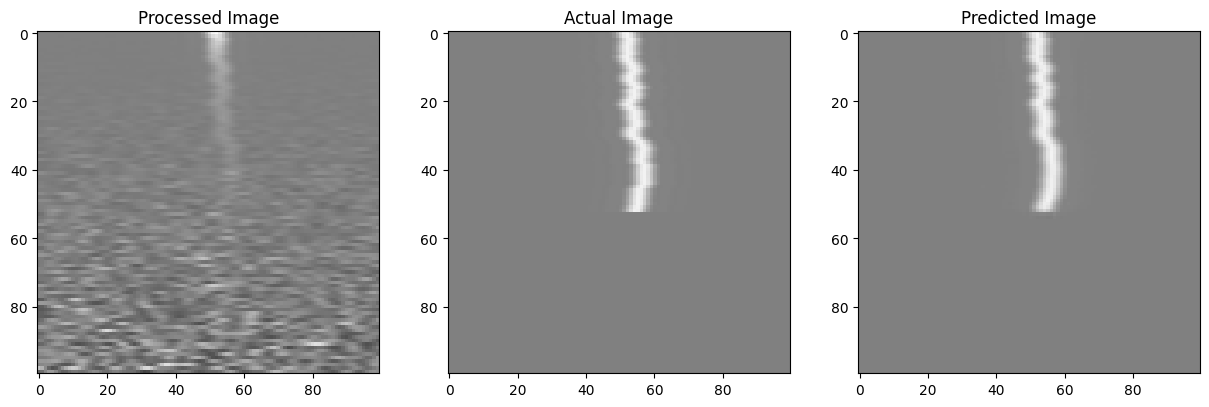

In [11]:
def VisualizeResults(index):
    real = x_test[index]
    pred = unet.predict(real[np.newaxis, ...])[0, :, :, 0]
    fig, arr = plt.subplots(1, 3, figsize=(15, 5))
    arr[0].imshow(real[14:114, 14:114], cmap="gray", vmin=-2, vmax=2)
    arr[0].set_title("Processed Image")
    arr[1].imshow(y_test[index, 14:114, 14:114, 0], cmap="gray", vmin=-1, vmax=1)
    arr[1].set_title("Actual Image")
    arr[2].imshow(pred[14:114, 14:114], cmap="gray", vmin=-1, vmax=1)
    arr[2].set_title("Predicted Image")


index = 0
VisualizeResults(index)

1/1 [==============================] - 0s 12ms/step


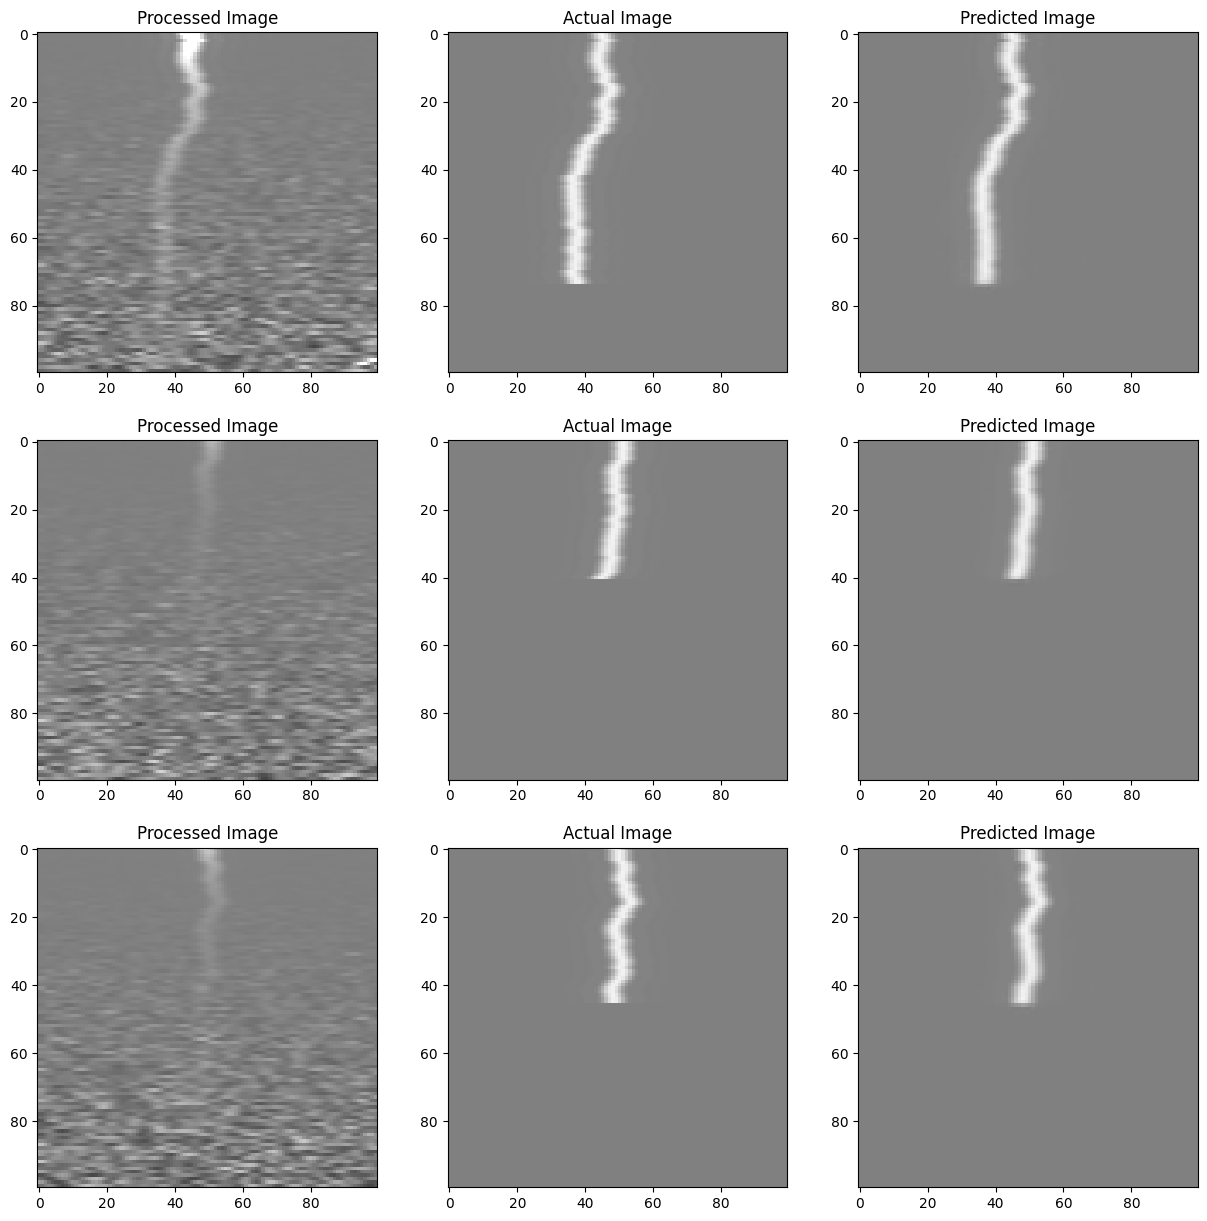

In [12]:
# Results of Validation Dataset
def VisualizeResults(list):
    fig, arr = plt.subplots(len(list), 3, figsize=(15, 15))
    for i in range(len(list)):
        index = list[i]
        real = x_test[index]
        pred = unet.predict(real[np.newaxis, ...])[0, :, :, 0]
        arr[i][0].imshow(real[14:114, 14:114], cmap="gray", vmin=-2, vmax=2)
        arr[i][0].set_title("Processed Image")
        arr[i][1].imshow(y_test[index, 14:114, 14:114, 0], cmap="gray", vmin=-1, vmax=1)
        arr[i][1].set_title("Actual Image")
        arr[i][2].imshow(pred[14:114, 14:114], cmap="gray", vmin=-1, vmax=1)
        arr[i][2].set_title("Predicted Image")


# Add any index to contrast the predicted mask with actual mask
test_list = range(100, 103)
VisualizeResults(test_list)

In [13]:
# evaluation scheme
y_test1 = y_test[:, 14:114, 14:114, 0]
y_pred1 = unet.predict(x_test)[:, 14:114, 14:114, 0]

2023-11-01 18:07:57.636252: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 131072000 exceeds 10% of free system memory.
2023-11-01 18:07:57.706845: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 131072000 exceeds 10% of free system memory.


63/63 [==============================] - 1s 16ms/step


2023-11-01 18:07:59.238805: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 131072000 exceeds 10% of free system memory.


In [14]:
mask1 = np.full((100, 100), 1)
mask2 = np.repeat(np.linspace(0, 99, 100)[np.newaxis, :], 100, axis=0)

y_t = np.sum(y_test1 * mask2, axis=2) / np.sum(y_test1 * mask1, axis=2)
y_p = np.sum(y_pred1 * mask2, axis=2) / np.sum(y_pred1 * mask1, axis=2)

y_p[np.average(y_pred1 * mask1, axis=2) < 0.04] = np.nan

y_p_range = []
for y in y_p:
    rng = np.where(np.isnan(y))[0][0]
    # print(y)
    y_p_range.append(rng)
y_p_range = np.array(y_p_range)

y_d = y_p - y_t

y_t_avg = np.average((y_t - np.average(y_t, axis=0)) ** 2, axis=0) ** 0.5
y_d_avg = np.nanmean(y_d**2, axis=0) ** 0.5

/tmp/ipykernel_2990376/1950677031.py:4: RuntimeWarning: invalid value encountered in divide
  y_t = np.sum(y_test1 * mask2, axis=2) / np.sum(y_test1 * mask1, axis=2)
/tmp/ipykernel_2990376/1950677031.py:19: RuntimeWarning: Mean of empty slice
  y_d_avg = np.nanmean(y_d**2, axis=0) ** 0.5


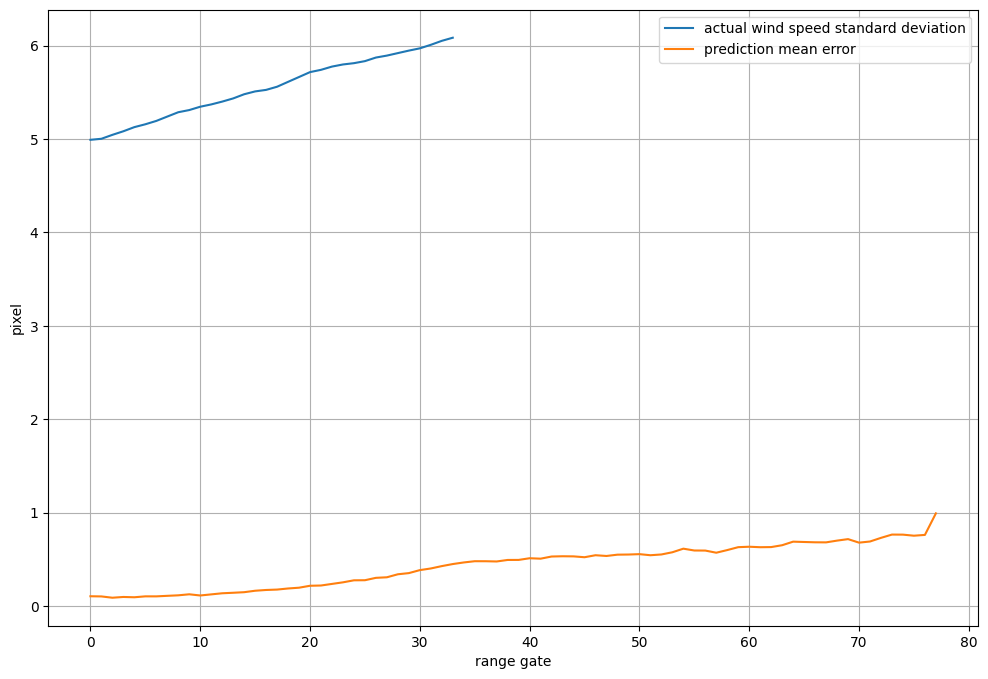

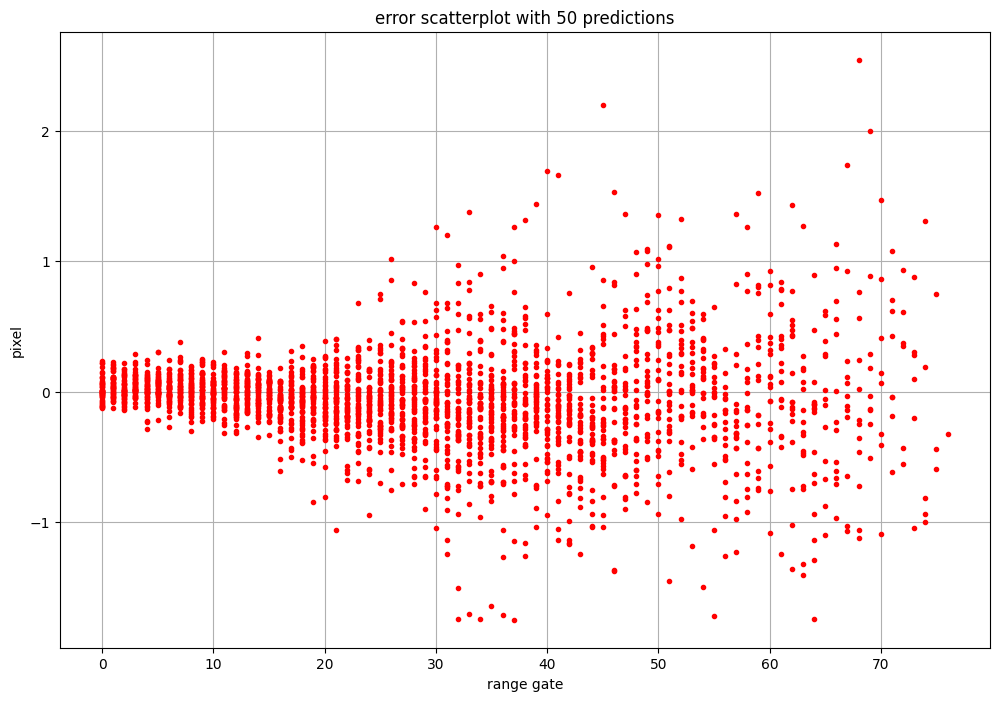

In [15]:
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(y_t_avg, "-", label="actual wind speed standard deviation")
plt.plot(y_d_avg, "-", label="prediction mean error")
plt.xlabel("range gate")
plt.ylabel("pixel")
plt.legend()
plt.grid()
plt.show()

for i in y_d[:50]:
    plt.plot(i, ".r")
plt.xlabel("range gate")
plt.ylabel("pixel")
plt.title("error scatterplot with 50 predictions")
plt.grid()
plt.show()

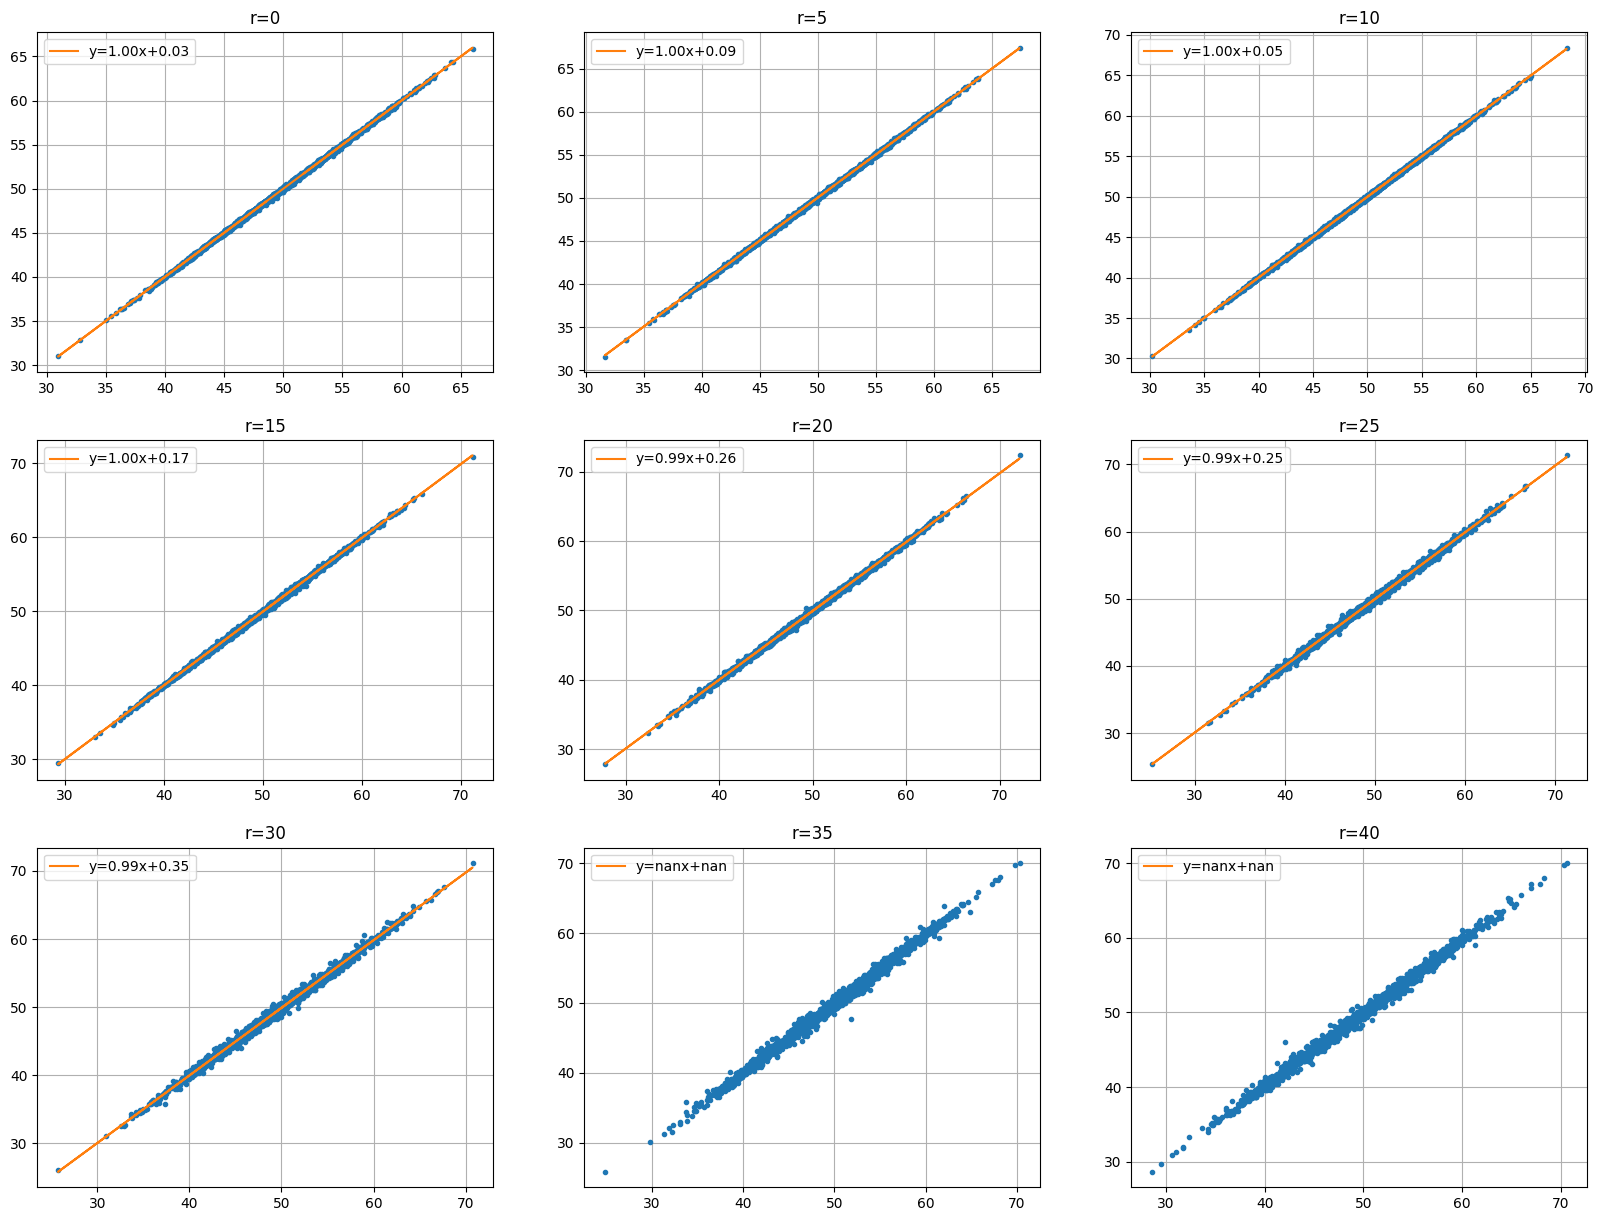

In [16]:
fig, arr = plt.subplots(3, 3, figsize=(20, 15))
arr = np.reshape(arr, (-1,))

for i in range(9):
    range_gate = i * 5
    xs = y_t[:, range_gate]
    ys = y_p[:, range_gate]
    fit = np.polyfit(xs[xs > 0], ys[xs > 0], 1)
    arr[i].plot(xs, ys, ".")

    arr[i].plot(xs, fit[0] * xs + fit[1], label="y={:.2f}x{:+.2f}".format(fit[0], fit[1]))
    arr[i].set_title("r=" + str(range_gate))
    arr[i].grid()
    arr[i].legend()

In [17]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          80        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 8)          584       ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 8)          32        ['conv2d_1[0][0]']            
 Normalization)                                                                               